# Indentification of Semantic Duplicates
## Dilettante Dive into the Quora Data Set

# Introduction

Finding and quantifying semantic patterns is key to successful natural
language processing and knowledge organisation. One of the most
important challenges in NLP is determining whether two texts have the
same intent or not, and machine learning techniques provide us a
necessary and diverse toolset to approach this problem.
In January 2017, [Quora published its first public data set](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) on
duplicate and related human-labelled questions compiled from the
actual Quora data. How can we use it to predict whether two
question-strings are duplicate or not?

## Loading Modules and Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt # visualisation

training_filename = "data/train.csv"
testing_filename = "data/test.csv"
training_data = pd.read_csv(training_filename, encoding = 'utf8')

Let's get a sneak peek at the training data at hand:

In [2]:
training_data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


We are given the following parameters:

-   **id** - the id of a training set question pair
-   **qid1**, **qid2** - unique ids of each question
-   **question1**, **question2** - the full text of each question
-   **is\_duplicate** - the target variable, set to 1 if question1 and
    question2 have essentially the same meaning, and 0 otherwise.

In [3]:
print('There are {} question pairs available for training.'.format(len(training_data)))
print('Among them, {}% are duplicates.'.format(round(training_data['is_duplicate'].mean()*100, 2)))
# find unique question ids
qids = pd.Series(training_data['qid1'].tolist() + training_data['qid2'].tolist())
print('There are {} unique questions considered.'.format(len(np.unique(qids))))
print('The number of questions that appear multiple times is {}.'.format(np.sum(qids.value_counts() > 1)))

There are 404290 question pairs available for training.
Among them, 36.92% are duplicates.
There are 537933 unique questions considered.
The number of questions that appear multiple times is 111780.


Let's look at the distribution of question lengths:

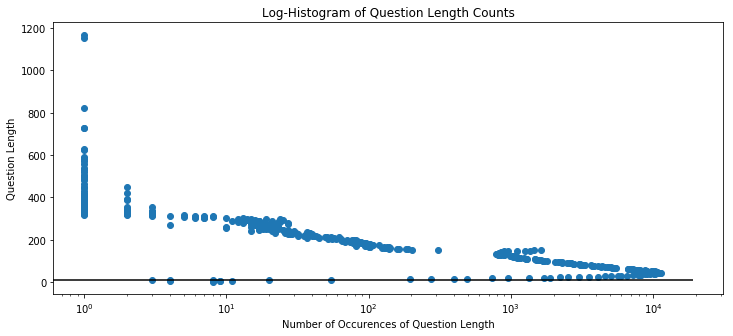

In [4]:
questions = pd.Series(list(set(training_data['question1'].tolist() + training_data['question2'].tolist())))
question_lengths = questions.str.len().value_counts()
plt.figure(figsize=(12, 5))
plt.scatter(question_lengths, question_lengths.index)
plt.xscale('log', nonposy='clip')
plt.title('Log-Histogram of Question Length Counts')
plt.xlabel('Number of Occurences of Question Length')
plt.ylabel('Question Length')
plt.hlines(10, 0, 1.9e4)
plt.show()

It seems that there is a minority of very short questions. We will see
whether dropping them from the training data set will help us improve
the accuracy of predictions.

## Balancing Classes

We have already noticed that in the training data set the number of
duplicates constitute about a third of the entire corpus. This may
skew our predictions by increasing the number of false positives.
There are 2 approaches I have tried to remediate this problem:

-   generate an additional set of duplicate questions by
    replacing each noun in a randomly chosen duplicate question with its
    synonym, increasing the percentage content of duplicate questions to a
    half of the entire data sets
-   apply up-down scaling to the training dataframe, decreasing the
    percentage content to about a fifth of the entire dataframe, which
    [was estimated](https://www.kaggle.com/badat0202/estimate-distribution-of-data-in-lb) to be close to the percentage content of duplicates in
    the test data set

## Cleaning Data

Our cleaning-up process is threefold:

1.  We remove unnecessary punctuation, pad the words, deal with
    non-ascii characters and fix simple typos.
2.  SpaCy is used to replace quantities and other entities
    with something more amenable to later processing by our machine
    learning model.
3.  We remove questions deemed too short to bear any meaningful content.
4.  Finally, we oversample duplicates.

## Dealing with Missing Packages

Since reproducible builds of [NixOS](https://nixos.org/) disallow the vanilla usage of `pip`
for Python package management, we [first](https://github.com/NixOS/nixpkgs/pull/25804) [add](https://github.com/NixOS/nixpkgs/pull/25791) tools like `gensim` and
`spaCy` to [Nixpkgs](https://nixos.org/nixpkgs/manual/).
Now we are ready to proceed:

In [1]:
from preprocess import Preprocessor
prep = Preprocessor(training_filename)
training_data = prep.processed_questions()

We save the data sets after each step so that the corresponding models
could be compared later.

# Modelling

## Building Naive Models

To avoid the time-wasting bog of fine-tuning a deliberately chosen
model which might not be the best choice to analyse the data, we build
and improve upon a benchmark model.

### Naive

LSTM (long short-term memory) recurrent neural network with a
non-trainable word2vec embedding layer, inspired by [@lystdo](https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings), seems
suitable, considering the success of LSTM models in a diverse range of
natural language processing such as text compression and handwriting
recognition.
Note that we are going to train on the data set with oversampled and
perturbated positive class.

In [1]:
from models.naive_model import NaiveModel
nm = NaiveModel()
nm.predict()

Ten epochs of the model require substantial computing resources &#x2013;
running the snippet above took almost 17 hours on my laptop. The model
with minimal fine-tuning gives us a score of 0.31985, while the
logloss of the model validated on the training dataframe was 0.2480,
which we would now try to improve.

Our strategy is to identify relevant features and build a faster
model.

### Aleph

We will try to use less computationally expensive techniques.  
First of all, we dispense with recurrent neural networks in our naive
model and build upon [the work of Bradley Pallen](https://github.com/bradleypallen/keras-quora-question-pairs), constructing a
Siamese neural network with 300-dimensional Google News Word2Vec
embeddings branches passing through TimeDistributed Dense layers and
merged to be processed via fully-connected Dense layers activated with
ReLU.
Then we reweigh the classes to account for the disparity in the class
prevalence.

-   **Training data set**: oversampled
-   **Dense dimensions**: 137
-   **Dropout rate for hidden layers**: 0.38

In [1]:
from models.aleph_model import Aleph
aleph = Aleph()
aleph.predict()

For the speed the price is logloss: Aleph scores only 0.32497 on the
LB.
![img](img/accuracy_dynamics.png)

### Bet

-   based on Aleph
-   added kernel constraints to Dense layers to ensure the maximum norm
    does not exceed 3
-   ordered Dense layers in the form of an inverted pyramid
-   **Training data set**: oversampled
-   **Dense dimensions**: 126
-   **Dropout rate for hidden layers**: 0.37

In [1]:
from models.bet_model import Bet
bet = Bet()
bet.predict()

The model seems to undertrain, judging by the fact that the validation
accuracy is always bigger than the training accuracy, and gives us a
worse score 0.33641.

![img](img/2017-05-26-1043-beta_126_0.37-accuracy_dynamics.png)

### Vet

In [1]:
from models.vet_model import Vet
vet = Vet()
vet.predict()

-   based on Bet
-   made the choice of the dropout rate for hidden layers more uniform
    in the range 0.20 to 0.40
-   increased the hidden layer dimensions to the range [280, 300]
-   changed ReLU to PReLU
-   removed the dropout after the batch normalisation of the merge layer
-   removed kernel constraints
-   flattened the pyramidal structure of the hidden layers
-   **Training data set**: oversampled
-   **Dense dimensions**: 282
-   **Dropout rate for hidden layers**: 0.27

![img](img/2017-05-26-1818-vet_282_0.27-accuracy_dynamics.png)

The model evidently overtrains after the third epoch, and scores 0.35179, even
worse than all the other models we have looked at.

### Gimmel

In [1]:
from models.gimmel_model import Gimmel
gimmel = Gimmel()
gimmel.predict()

-   based on Vet
-   added Krzysztof Dziedzic's [magic feature II](https://www.kaggle.com/c/quora-question-pairs/discussion/33287), inspired by @justfor's [implementation](https://www.kaggle.com/justfor/edges/code)
-   added @tarobxl's [max kcore feature](https://www.kaggle.com/c/quora-question-pairs/discussion/33371).
-   feeding custom features through a separate hidden layer with
    sandwiching dropout and batch normalisation
-   increased the range of the dropout rate to [0.25, 0.50]
-   decreased the range of the hidden dimensions to [190, 275]
-   organised the hidden layers into the pyramidal form
-   switched to adam with a clipnorm as an optimizer
-   changed the training data set
-   **Training data set**: spaCy-treated, with shorties trimmed
-   **Dense dimensions**: 214
-   **Dropout rate for hidden layers**: 0.42

![img](img/2017-05-27-1204-gimmel_214_0.42-accuracy_dynamics.png)

The magic features play in, giving us the Public LB score of 0.24602.

### Dalet

In [1]:
from models.dalet_model import Dalet
dalet = Dalet()
dalet.predict()

-   based on Gimmel
-   custom features as a *pure* input layer with Dropout
-   added [@abhishek's features](https://github.com/abhishekkrthakur/is_that_a_duplicate_quora_question) [provided](https://www.kaggle.com/c/quora-question-pairs/discussion/31284) by @raddar
-   **Training data set**: spaCy-treated, with shorties trimmed
-   **Dense dimensions**: 242
-   **Dropout rate for hidden layers**: 0.32

![img](img/2017-05-27-1945-dalet_242_0.32-accuracy_dynamics.png)

The performance is very similar to Gimmel's, but Dalet seems to
overfit more, as reflected in its score of 0.24801.

### He

In [1]:
from models.he_model import He
he = He()
he.predict()

-   based on Dalet
-   used the train data set with words stemmed and stopwords removed

In [1]:
from helpers.stem import Stem
s = Stem()
s.stem_questions()

-   removed @abhishek's features in the attempt to avoid overfitting
-   added @jturkewitz's [magic feature](https://www.kaggle.com/jturkewitz/magic-features-0-03-gain)

In [1]:
from helpers.magic import Magic
m = Magic()
m.spell()

-   added a hidden layer for custom features for feature detection
-   **Training data set**: spaCy-treated, with shorties trimmed, words
    stemmed and stopwords removed
-   **Dense dimensions**: 199
-   **Dropout rate for hidden layers**: 0.49

![img](img/2017-05-28-0605-he_199_0.49-accuracy_dynamics.png) Now, the
model converges well, and no significant overlearning seems to
occur. However, the score jumps up to 0.26713, and I make a hypothesis
that stemming is to blame.

### Vav

In [1]:
from models.vav_model import Vav
vav = Vav()
vav.predict()

-   based on the naive model (switched to LSTM)
-   removed stemming, with stopwords still excluded

In [1]:
from helpers.stopword import StopwordTrim
s = StopwordTrim()
s.remove_stopwords()

-   **Training data set**: spaCy-treated, with shorties trimmed and stopwords removed
-   **Dense dimensions**: 198
-   **Dropout rate for hidden layers**: 0.46

![img](img/2017-05-28-2256-vav_198_0.46-accuracy_dynamics.png)
The model converges quickly and seems to underlearn, but gives the
best score so far &#x2013; 0.24360.

### Zayin

In [1]:
from models.zayin_model import Zayin
zayin = Zayin()
zayin.predict()

-   based on Vav
-   included Abhishek's features
-   increased the dimensionality of the Dense layer for custom features
    to the default for the others
-   **Training data set**: spaCy-treated, with shorties trimmed and stopwords removed
-   **Dense dimensions**: 215
-   **Dropout rate for hidden layers**: 0.40

![img](img/2017-05-29-1751-zayin_215_0.40-accuracy_dynamics.png)

As we can see on the graph, the model is not as stable as the others
in the beginning, but converges after the 7 epoch. The disparity
between the training and validation set is not as big now if compared
with Vav's, but the public LB score of 0.25464 indicates that the
model generalises a bit worse than Vav.

### Khet

In [1]:
from models.khet_model import Khet
khet = Khet()
khet.predict()

-   based on Zayin (switched from LSTM to the Convolution1D layers with
    with GlobalMaxPooling1D and PReLU activation for the embedding
    layers to improve the speed of training)
-   removed Abhishek's features in the attempt to improve generalisation
-   **Training data set**: spaCy-treated, with shorties trimmed and stopwords removed
-   **Dense dimensions**: 261
-   **Dropout rate for hidden layers**: 0.41

![img](img/2017-05-29-2059-khet_261_0.41-accuracy_dynamics.png)

We pay the price for delegating feature extraction to the model with
speed, receiving the score of 0.27044.

## Comparing Models and Ensembling

One of the ways to improve our prediction accuracy is to ensemble the
different predictions we have.
We resort to GM and AM averaging.
First, let's combine all our predictions into one with the help of a
geometric mean:

In [1]:
import glob
import pandas as pd
from scipy.stats.mstats import gmean

predPath = "ensembling/"
models = []

for file_name in glob.glob(predPath + '*.csv'):
    df = pd.read_csv(file_name, encoding = "utf-8")
    models.append(df.ix[:, :1])

total = pd.concat(models, axis=1)
gm_df = pd.DataFrame()
gm_df['is_duplicate'] = gmean(total, axis=1)
gm_df['test_id'] = df.ix[:,1]
gm_df.to_csv("gm_ensemble.csv", index=False)

This simple procedure got us a score of 0.21736, which is an increase
of 0.02624 from the score of Vav, our best model.

Now, we attempt rank averaging to improve our result.

In [1]:
GLOB_PREDICTIONS = "./ensembling/*"
RK_AVG_OUTPUT = "./rk_avg_ensemble.csv"

from collections import defaultdict
from glob import glob

def rk_avg_ensemble(glob_files, loc_outfile):
  # write to the chosen file
  with open(loc_outfile,"w") as outfile:
    # store the raw ranks
    # keys are in the form (<line number>, <id>)
    all_ranks = defaultdict(list)
    # i is needed to write the header of the output file
    for i, glob_file in enumerate( glob(glob_files) ):
      # define a container for the ranks found in a file
      file_ranks = []
      print("Parsing now:", glob_file)
      # sort <glob_file> by the predicted probability, ignoring the first line
      lines = open(glob_file).readlines()
      lines = [lines[0]] + sorted(lines[1:])
      for line_number, line in enumerate( lines ):
        if line_number == 0 and i == 0:
          outfile.write( line )
          # if the line is not a header, process it
        elif line_number > 0:
          # store the row in a list
          row = line.strip().split(",")
          # <row[0]> is the predicted probability
          # <row[1]> is the id of the question
          file_ranks.append( (float(row[0]), int(row[1])) )
          # sort by the initially predicted probability
          # and give it a rank
      for rank, container in enumerate( sorted(file_ranks) ):
        # Store the rank in the dictionary for further processing.
        # The key is in the form <id>.
        all_ranks[container[1]].append(rank)

    print("The number of lines with the stored ranks: {}.".format(len(all_ranks.keys())))
    
    # define a list as a container for the average ranks
    average_ranks = []
    # k is in the form (<line number>, <id>);
    # first sort by the id
    for identifier in sorted(all_ranks):      
      # append the average rank together with the identifier
      average_ranks.append((sum(all_ranks[identifier])/len(all_ranks[identifier]),
                            identifier))
      # define a list as a container for the sorted ranks
    normalised_ranks = []
    # the element of the <average_ranks> is in the format
    # (<average_rank>, <identifier>), where
    # <identifier> is <test_id>
    
    for rank, avg_rk_obj in enumerate(sorted(average_ranks)):
      # sort <average_ranks> by the average rank and
      # append (<id>, <normalized probability>)
      # to <sorted_ranks> 
      normalised_ranks.append((avg_rk_obj[1],
                               rank/(len(average_ranks)-1)))
      # norm_prob_obj is in the format
      # (<id>, <normalised probability>)
      # sort <normalised_ranks> by <test_id> and write to the file
    for norm_prob_obj in sorted(normalised_ranks):
      outfile.write("{},{}\n".format(norm_prob_obj[1],
                                     norm_prob_obj[0]))
      print("Saved the normalised probabilites to {}.".format(loc_outfile))

rk_avg_ensemble(GLOB_PREDICTIONS, RK_AVG_OUTPUT)

Unfortunately, this approach does not yield anything useful, scoring
at 0.90852, which is probably due to the fact that the estimated
number of duplicates is only a fifth of the entire data
set.

Now we will try the weighted arithmetic mean.

First, let's define a WAM ensembling function which we are going to
use throughout our analysis.

In [1]:
def ensemble(weights, output):
    import glob
    import pandas as pd

    weighted_models = []
    for file_name in glob.glob(predPath + '*.csv'):
        df = pd.read_csv(file_name, encoding = "utf-8")
        weighted_models.append((df['is_duplicate'],weights[file_name]))
    
    wam_df = df['is_duplicate'] * 0.0
    
    for model, weight in weighted_models:
        wam_df += model * weight
    wam_df /= sum(weights.values())    
        
    wam_df = pd.concat([df['test_id'], wam_df], axis=1)
    wam_df.to_csv(output, index=False)

Now, we rank the models which we want to ensemble.

In [1]:
predPath = "ensembling/"
weights = {
# PB Scores are given above the file name
#0.25464
predPath + "0.2092_zayin_215_0.40.csv":2, 
#0.24360
predPath + "0.2200_vav_198_0.46.csv":5,
#0.26713
predPath + "0.2217_he_199_0.49.csv":1,
#0.24602
predPath + "0.2346_gimmel_214_0.42.csv":4,
#0.24801
predPath + "0.2364_dalet_242_0.32.csv":3
}

ensemble(weights, "wam_ensemble.csv")

Weighted AM turns out to yield the best score so far, giving 0.21623
 &#x2013; we will try to improve it by building better models.

## Constructing a Library of Models

What can we learn about the data set without embedding the texts into
the 300-dimensional vector space and letting the neural net out on the
embeddings, which might not be representative of the semantics due to
inevitable typos and other oddities of formatting?

We will try to find out by building XGBoost models trained on
hand-picked features.

### Tet

-   built metrics and XGBoost model [inspired by @act444](https://www.kaggle.com/act444/lb-0-158-xgb-handcrafted-leaky).

In [1]:
from custom.features import CustomFeatures
cf = CustomFeatures()
cf.run()

-   removed Abhishek's features
-   **Training data set**: spaCy-treated, with shorties trimmed and stopwords removed
-   **Result**: 0.24224
-   **Features Importance**:

![img](img/2017-05-30-1512-0.222026460989_tet_xgboost-feature_importance.png)

### Yud

In [1]:
from models.yud_model import Yud
yud = Yud()
yud.predict()

-   based on Tet
-   changed base score to 0.175 from 0.2
-   added Abhishek's features
-   **Training data set**: spaCy-treated, with shorties trimmed and stopwords removed
-   **Training result**: 0.2244, which is worse than the training result
    of Tet (0.22437), hence Yud's predictions were not submitted
-   **Features Importance**:

![img](img/2017-05-30-1553-0.224371846975_yud_xgboost-feature_importance.png)
Notice how significant Abhishek's features are, given that they
provide vital information about the NLP features of questions.

### Kaf

In [1]:
from models.kaf_model import Kaf
kaf = Kaf()
kaf.predict()

-   based on Yud
-   changed the training data set to include stopwords

In [1]:
from magic import Magic
TRAIN_DATA_FILENAME = "2017-05-24-1818-shorties_trimmed_train"
m = Magic(train_data_filename=TRAIN_DATA_FILENAME)
m.spell()

from custom.features import CustomFeatures
cf = CustomFeatures(train_data_filename=TRAIN_DATA_FILENAME)
cf.run()

-   changed `max_depth` from 7 to 10 and `subsample` from 0.6 to 0.55
-   **Training data set**: spaCy-treated, with shorties trimmed
-   **Result**: 0.24253
-   **Features Importance**:

![img](img/2017-05-30-1801-0.214863010529_kaf_xgboost-feature_importance.png)
Notice how the priority of `tfidf_wm` feature increases with stopwords
included. The new settings of the model, however, decrease its
predictive power.

### Lamed

In [1]:
from models.lamed_model import Lamed
lamed = Lamed()
lamed.predict()

-   trying ensembling with 5 classifiers, inspired by [@emanuele's work](https://github.com/emanuele/kaggle_pbr/blob/master/blend.py)
-   **Training data set**: spaCy-treated, with shorties trimmed
-   **Result**: 0.24785
-   The result is surprisingly good for the time spent training the model.

### Attempt at Repeated Ensembling

We will try to ensemble again to see whether Lamed gives us any improvement.

In [1]:
predPath = "ensembling/"
weights = {
# PB Scores are given above the file name
#0.21623
predPath + "wam_ensemble.csv":8,
#0.21736
predPath + "gm_ensemble.csv":7,
#0.24224
predPath + "0.222026460989_tet_xgboost.csv":6,
#0.24253
predPath + "0.214863010529_kaf_xgboost.csv":5,
#0.24360
predPath + "0.2200_vav_198_0.46.csv":4,
#0.24602
predPath + "0.2346_gimmel_214_0.42.csv":3,
#0.24785
predPath + "0.319533794385_lamed_xgboost.csv":2,
#0.24801
predPath + "0.2364_dalet_242_0.32.csv":1
}

ensemble(weights, "wam_ensemble_1.csv")

Indeed, the second ensemble scores 0.20882, which is the best score so
far. What if we ensemble again?

In [1]:
predPath = "ensembling/"
weights = {
    # PB Scores are given above the file name
    #0.20882
    predPath + "wam_ensemble_1.csv":8,
    #0.21623
    predPath + "wam_ensemble.csv":7,
    #0.21736
    predPath + "gm_ensemble.csv":6,
    #0.24224
    predPath + "0.222026460989_tet_xgboost.csv":5,
    #0.24253
    predPath + "0.214863010529_kaf_xgboost.csv":4,
    #0.24360
    predPath + "0.2200_vav_198_0.46.csv":3,
    #0.24602
    predPath + "0.2346_gimmel_214_0.42.csv":2,
    #0.24785
    predPath + "0.319533794385_lamed_xgboost.csv":1
}
ensemble(weights, "wam_ensemble_2.csv")

The third ensemble is worse than the parental second, which is
consistent with [the reports](https://mlwave.com/kaggle-ensembling-guide/) that weighted AM ensembling works better
with the least correlated predictions.

### Mem

In [1]:
from models.mem_model import Mem
mem = Mem()
mem.predict()

-   based on Lamed
-   added NN MLPClassifier with pyramidal structure of three hidden layers
-   removed Lamed's GradientBoostingClassifier
-   changed the number of estimators to 180 each
-   **Training data set**: spaCy-treated, with shorties trimmed
-   **Result**: 0.24785

The model received the worst score of 6.55941 after very quick
training, which indicates severe overfitting.

### Nun

In [1]:
from models.nun_model import Nun
nun = Nun()
nun.predict()

-   based on He
-   changed the training data set (included stopwords)
-   wrote the code for computing similarity measures based on NLTK
    WordNet and Brown corpora, but decided against their inclusion due
    to the speed of their computation

In [1]:
from custom.similarity import SimilarityFeatures
sf = SimilarityFeatures(train_data_filename="2017-05-24-1818-shorties_trimmed_train")
sf.run()

-   added Abhishek's features with `euclidean_distance` and
    `jaccard_distance` dropped, as suggested by their feature importance
-   added Dropout layers to `Q1`, `Q2` and `custom_features` branches
    before the merging layer
-   swapped places of dropout and batch normalisation layers after merging
-   decreased the dropout rate for the question layers
-   decreased the dimension of the dense layer for custom features
-   added up-down sampling
-   changed the optimizer to nadam
-   added custom features
-   removed reweighing
-   **Training data set**: spaCy-treated, with shorties trimmed
-   **Base dense dimensions**: 407
-   **Base dropout rate for hidden layers**: 0.47

![img](img/2017-06-04-1743-nun_407_0.47-accuracy_dynamics.png)
The score obtained is 0.24987, which is an improvement from He's
0.26713.

### Samech

In [1]:
from models.samech_model import Samech
samech = Samech()
samech.predict()

-   based on Kaf
-   decreased `eta` to 0.01 to prevent overfitting
-   increased `max_depth` to 8 to make the model more complex
-   increased base score to 0.19
-   removed Abhishek's features
-   **Training data set**: spaCy-treated, with shorties trimmed

![img](img/2017-06-02-2225-0.212772886818_samech_xgboost-feature_importance.png)
The score of 0.24505 is worse than Kaf's 0.24253, which is probably
due to the lack of good features. We have already seen in Yud's
predictions that including Abhishek's can boost the results, so this
run was not productive &#x2013; the model does seem to learn more from less,
however.

### Pe

In [1]:
from models.pe_model import Pe
pe = Pe()
pe.predict()

-   based on Mem without MLPClassifier
-   switched to mlxtend StackedClassifier without folding
-   **Training data set**: spaCy-treated, with shorties trimmed-
-   overfits significantly &#x2013; LB Score of 0.42179

### Phe

In [1]:
from models.phe_model import Phe
phe = Phe()
phe.predict()

-   based on Pe
-   removed minimax regularization of predictions
-   Increased the dimensions of MLPClassifier and squashed the pyramidal architecture of hidden layers
-   Decreased the batch\_size of MLPClassifier
-   **Training data set**: spaCy-treated, with shorties trimmed-
-   overfits extremely &#x2013; LB Score of 6.29678, consistent with Mem's
    poor result, which is probably due to the addition of MLPClassifier

### Tsadi

In [1]:
from models.tsadi_model import Tsadi
tsadi = Tsadi()
tsadi.predict()

-   based on Nun (switched to LSTM)
-   removed one Dense layer
-   decreased the dropout rate for the question branches
-   **Training data set**: spaCy-treated, with shorties trimmed
-   was not run due to the computational cost and realisation that
    more careful base data selection is necessary

### Quf

In [1]:
from models.quf_model import Quf
quf = Quf()
quf.predict()

-   based on Yud
-   changed the base dataframe to the train file with minimal preprocessing
-   excluded magic2 and kcore features
-   added Abhishek's `euclidean_distance` and `jaccard_distance`
-   **Training data set**: vanilla

In [1]:
from magic import Magic
TRAIN_DATA_FILENAME = "vanilla_train"
m = Magic(train_data_filename=TRAIN_DATA_FILENAME)
m.spell()

from custom.features import CustomFeatures
cf = CustomFeatures(train_data_filename=TRAIN_DATA_FILENAME)
cf.run()

Indeed, Abhishek's `euclidean_distance` and `jaccard_distance` are the
least significant features and may just add a noise to the model. The
score received was 0.23158, which is  an improvement from Tet's
0.24224. It seems that `vanilla_train` gives better results.

![img](img/2017-06-04-1949-0.180881032724_quf_xgboost-feature_importance.png)

-

## Attempt at Ensembling

We ensemble our best model for the fourth time.

In [1]:
predPath = "ensembling/"
n = 9
weights = {
    # PB Scores are given above the file name
    #0.23158
    predPath + "0.180881032724_quf_xgboost.csv":n,
    #0.24224
    predPath + "0.222026460989_tet_xgboost.csv":n-1,
    #0.24253
    predPath + "0.214863010529_kaf_xgboost.csv":n-2,
    #0.24360
    predPath + "0.2200_vav_198_0.46.csv":n-3,
    #0.24505
    predPath + "0.212772886818_samech_xgboost.csv":n-4,
    #0.24602
    predPath + "0.2346_gimmel_214_0.42.csv":n-5,
    #0.24785
    predPath + "0.319533794385_lamed_xgboost.csv":n-6,
    #0.24801
    predPath + "0.2364_dalet_242_0.32.csv":n-7,
    #0.24987
    predPath + "0.1339_nun_407_0.47.csv":n-8
}
ensemble(weights, "wam_ensemble_3.csv")

Again, this boosts us to 0.20767, which is an improvement from the
`wam_ensemble1.csv` result of 0.20882.

## Feature Engineering

The dilettante model meddling did not give satisfactory results. We
need more features.

### NLTK Investigations

-   measuring shares of hypernyms and lemmas, as well as linear and
    smooth counts of synonyms
-   cross path similarity is not computed due to the high computational cost

We will plot how good the features are for the discrimination between
dupes and non-dupes.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
BASE_DIR = 'data/'
TRAIN_DATA_FILENAME = "vanilla_train"
TRAIN_DATA_FILE = BASE_DIR + TRAIN_DATA_FILENAME + '.csv'
CUSTOM_FEATURES_TRAIN = 'custom/' + \
                        TRAIN_DATA_FILENAME + \
                        "-nltk-train.csv"
df_train = pd.read_csv(TRAIN_DATA_FILE, encoding="utf-8")
nltk_features = pd.read_csv(CUSTOM_FEATURES_TRAIN, encoding="utf-8")

ix_is_dup = np.where(df_train['is_duplicate'] == 1)[0]
ix_not_dup = np.where(df_train['is_duplicate'] == 0)[0]


def plot_feature_graph(data, fname):
    fig = plt.figure()
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax1.set_title('Distribution of %s' % fname, fontsize=16)
    sns.distplot(data[fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(data.loc[ix_is_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='duplicate')    
    sns.distplot(data.loc[ix_not_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='non-duplicate')
    ax2.legend(loc='upper right', prop={'size': 14})
    plt.savefig("img/{}.png".format(fname))
    plt.show()

In [1]:
plot_feature_graph(nltk_features,"hypernyms_share")
plot_feature_graph(nltk_features,"linear_synonyms_count")
plot_feature_graph(nltk_features,"smooth_synonyms_count")
plot_feature_graph(nltk_features,"lemmas_share")

![img](img/hypernyms_share.png)
![img](img/linear_synonyms_count.png)
![img](img/smooth_synonyms_count.png)
![img](img/lemmas_share.png)

We can see that `linear_synonyms_count` and `smooth_synonyms_count`
allow almost no differentiation at all, so we exclude them from our
models.

### Properties of words

Texts with similar contents might have similar syllables and character frequences.

In [1]:
wordies_features = pd.read_csv('custom/' + TRAIN_DATA_FILENAME + "-wordies-train.csv", encoding="utf-8")
plot_feature_graph(wordies_features,"character_freq")
plot_feature_graph(wordies_features,'syllable_similarity')

![img](img/character_freq.png)

![img](img/syllable_similarity.png)
Here we may discard the character frequencies, since they are almost
completely overlapping.

### Testing word and synonym properties

#### Resh

In [1]:
from models.resh_model import Resh
resh = Resh()
resh.predict()

-   based on Quf, with magic2 and kcore features included
-   **Training data set**: vanilla

![img](img/2017-06-05-0748-0.180005762885_resh_xgboost-feature_importance.png)

-   Resh model scores 0.23214, which is worse than Quf, and the
    `character_freq` seems to be important despite the massive
    overlap. Probably `euclidean_distance`, `jaccard_distance` and
    `character_freq` contribute to the decline of the model
    generalisability.

### Counts Investigation

Now we try to measure several set statistics: Wagner-Fischer,
MostFreqKSDF, Tversky index, weighted difference, stem frequencies,
and stem sharing.

In [1]:
from custom.counts_investigation import CountsFeatures
c = CountsFeatures()
c.run()

In [1]:
env_features = pd.read_csv('custom/' + TRAIN_DATA_FILENAME + "-counts-train.csv", encoding="utf-8")
plot_feature_graph(env_features,"wagner_fischer")
plot_feature_graph(env_features,'wagner_fischer_reverse')
plot_feature_graph(env_features,'most_freq_2_sdf')
plot_feature_graph(env_features,'most_freq_2_sdf_reverse')
plot_feature_graph(env_features,'most_freq_2_sdf_reverse')
plot_feature_graph(env_features,'stems_freq')
plot_feature_graph(env_features,'stems_share')
plot_feature_graph(env_features,'stems_weighted_difference')
plot_feature_graph(env_features,'stems_tversky_index')
del env_features

![img](img/wagner_fischer.png)

![img](img/wagner_fischer_reverse.png)

 ![img](img/most_freq_2_sdf_reverse.png)
 ![img](img/most_freq_2_sdf_reverse.png)
 ![img](img/most_freq_2_sdf_reverse.png)
  ![img](img/stems_freq.png)
  ![img](img/stems_share.png)
  ![img](img/stems_weighted_difference.png)
  ![img](img/stems_tversky_index.png)
Only the last four features seem to be worthy to be included in our next model.

### Environment Investigation

Now let's represent each sentence as one continuous string of stemmed
words and calculate several similarity statistics on them.

In [1]:
from custom.environment_investigation import EnvFeatures
e = EnvFeatures()
e.run()

In [1]:
env_features = pd.read_csv('custom/' + TRAIN_DATA_FILENAME + "-env-train.csv", encoding="utf-8").fillna(0)
plot_feature_graph(env_features,'kendall_tau')
plot_feature_graph(env_features,'kendall_p_value')
plot_feature_graph(env_features,'string_similarity')
plot_feature_graph(env_features,'subset_count')
del env_features

![img](img/kendall_tau.png)

![img](img/kendall_p_value.png)

![img](img/string_similarity.png)

![img](img/subset_count.png)
`kendall_p_value` and `string_similarity` seem to be worthy to be included into the model.

### Testing word, synonym, counts and environment properties

#### Shin

In [1]:
from shin_model import Shin
s = Shin()
s.predict()

-   based on Resh, with counts and environment features included
-   **Training data set**: vanilla

![img](img/2017-06-06-0147-0.178758220484_shin_xgboost-feature_importance.png)
The added features seem to be important and blend well with the rest,
giving a score of 0.22808, which is an improvement from Quf and Resh.

### Az Investigation

Questions with similar places mentioned seem to be more likely to
share the same intent. We use the Movehub City Rankings [data](https://www.kaggle.com/blitzr/movehub-city-rankings) to fetch
the country names together with some cities.

In [1]:
from custom.investigation_az import AzFeatures
az = AzFeatures()
az.run()

In [1]:
az_features = pd.read_csv('custom/' + TRAIN_DATA_FILENAME + "-az-train.csv", encoding="utf-8").fillna(0.0)
plot_feature_graph(az_features,'places_share')
# All zeroes.
#plot_feature_graph(az_features,'places_difference')
plot_feature_graph(az_features,'places_prevalence')
del az_features

![img](img/places_share.png)

![img](img/places_prevalence.png)
There is some differentiation, but not that much &#x2013; not many questions mention any countries at all.

### Buky Investigation

What can Word2Vec embeddings trained on Google News tell us?  We
introduce multiple features, all based on the vectors corresponding to
each word in the questions.

In [1]:
from custom.investigation_buky import BukyFeatures
buky = BukyFeatures()
buky.run()

### Collins & Duffy

We feed [Collins and Duffy's data](https://www.kaggle.com/c/quora-question-pairs/discussion/32334) in the hopes of retrieving some
information affecting the duplicity.

In [1]:
from custom.duffy import Duffy
d = Duffy()
d.build()

### Pagerank

We compute pageranks, [inspired by @ZFTurbo](https://www.kaggle.com/zfturbo/pagerank-on-quora-feature-file-generator/code).

In [1]:
from custom import pagerank

## New Models

Now we are ready to combine the features and feed them to our model

### Tav

In [1]:
from tav_model import Tav
t = Tav()
t.predict()

-   based on Shin, with the computed features included
-   **Training data set**: vanilla

![img](img/2017-06-06-2327-0.174476734017_tav_xgboost-feature_importance.png)
Luckily, we have found features which are more important than the ones used previously. Tav scores us 0.20662.

### Sin

With not much time under our belts, let's train something more
lightweight than LSTM but hopefully more accurate than vanilla NN.

In [1]:
from sin_model import Sin
s = Sin()
s.predict()

-   based on Khet (Convolutional1D with the custom features fed through a hidden layer)
-   all the best features included
-   trained for 5 total epochs due to time constraints, with a break
    in-between to change the number of epochs
-   **Training data set**: vanilla

![img](img/2017-06-07-0229-sin_323_0.46-accuracy_dynamics.png)

The model seems to be very stable, with some overfitting occuring by
the end of the third epoch. Sin yields 0.22727, which is worse than
Tav.

### WAM Ensemble 4

While Sin is being evaluated, let's ensemble what we have so far and
see what we get.

In [1]:
def ensemble(weights, output):
    import glob
    import pandas as pd

    weighted_models = []
    for file_name in glob.glob(predPath + '*.csv'):
        df = pd.read_csv(file_name, encoding = "utf-8")
        weighted_models.append((df['is_duplicate'],weights[file_name]))
    
    wam_df = df['is_duplicate'] * 0.0
    
    for model, weight in weighted_models:
        wam_df += model * weight
    wam_df /= sum(weights.values())    
        
    wam_df = pd.concat([df['test_id'], wam_df], axis=1)
    wam_df.to_csv(output, index=False)
predPath = "ensembling/"
n = 9
weights = {
    # PB Scores are given above the file name
    #0.20662
    predPath + "0.174476734017_tav_xgboost.csv":n+5,
    #0.20767
    predPath + "wam_ensemble_3.csv":n+4,
    #0.21736
    predPath + "gm_ensemble.csv":n+3,
    #0.22808
    predPath + "0.178758220484_shin_xgboost.csv":n+2,
    #0.23158
    predPath + "0.180881032724_quf_xgboost.csv":n+1,
    #0.23214
    predPath + "0.180005762885_resh_xgboost.csv":n,
    #0.24224
    predPath + "0.222026460989_tet_xgboost.csv":n-1,
    #0.24253
    predPath + "0.214863010529_kaf_xgboost.csv":n-2,
    #0.24360
    predPath + "0.2200_vav_198_0.46.csv":n-3,
    #0.24505
    predPath + "0.212772886818_samech_xgboost.csv":n-4,
    #0.24602
    predPath + "0.2346_gimmel_214_0.42.csv":n-5,
    #0.24785
    predPath + "0.319533794385_lamed_xgboost.csv":n-6,
    #0.24801
    predPath + "0.2364_dalet_242_0.32.csv":n-7,
    #0.24987
    predPath + "0.1339_nun_407_0.47.csv":n-8
}
ensemble(weights, "wam_ensemble_4.csv")

The ensembling gives us an improvement of more than 0.005.

### WAM Ensemble 5

Finally, let's apply the trick which we used in our first ensembling.
First, let's compute the GM ensemble of all the models which scored under 0.25.

In [1]:
import glob
import pandas as pd
from scipy.stats.mstats import gmean

predPath = "ensembling/"
models = []

for file_name in glob.glob(predPath + '*.csv'):
    df = pd.read_csv(file_name, encoding = "utf-8")
    models.append(df['is_duplicate'])

total = pd.concat(models, axis=1)
gm_df = pd.DataFrame()
gm_df['is_duplicate'] = gmean(total, axis=1)
gm_df['test_id'] = df['test_id']
gm_df.to_csv("gm_ensemble_1.csv", index=False)

Then we combine the three best models and take a weighted mean:

In [1]:
def ensemble(weights, output):
    import glob
    import pandas as pd

    weighted_models = []
    for file_name in glob.glob(predPath + '*.csv'):
        df = pd.read_csv(file_name, encoding = "utf-8")
        weighted_models.append((df['is_duplicate'],weights[file_name]))
    
    wam_df = df['is_duplicate'] * 0.0
    
    for model, weight in weighted_models:
        wam_df += model * weight
    wam_df /= sum(weights.values())    
        
    wam_df = pd.concat([df['test_id'], wam_df], axis=1)
    wam_df.to_csv(output, index=False)
predPath = "ensembling/"
n = 3
weights = {
    # PB Scores are given above the file name
    #0.20662
    predPath + "0.174476734017_tav_xgboost.csv":n,
    #0.20767
    predPath + "wam_ensemble_4.csv":n-1,
    #0.21067
    predPath + "gm_ensemble_1.csv":n-2
}
ensemble(weights, "wam_ensemble_5.csv")

The final ensemble scores 0.19638 on the public LB and 0.20098 on the private LB.

# Conclusion

QQP was a superb experience for me &#x2013; data, tips and knowledge
shared by the Kaggle community and all the other researchers working
on NLP were indispensable in the present investigation of the data
set. Given the fact that the only experience of machine learning I had
before was limited to using automatic translators, the competition
turned out to give valuable lessons in natural language processing and
powerful prediction methods.
Although the final score is not the best, it evidently shows that a
dilettante with some free time, programming experience and wonderful
receptive community can indeed beat the three quarters of
participants.
Key aspects of analysis which I would like to
improve in the future include the following:

-   some graphs look awful and not particularly informative, especially
    the diagrams on the feature importance &#x2013; using violin or scatter
    plots might be more useful
-   there must be a way to extract features found by different neural
    networks and inject them into the new model to boost accuracy
-   a diverse range of models should be tested &#x2013; only three frameworks
    (XGBoost, Keras NN, Scikit stacking) were tested in the present
    analysis &#x2013; and looking at, for example, H2o and LightGBM may help
-   methodical approach to tweaking the model parameters should be
    adopted &#x2013; predictions here were fine-tuned based on the shaky
    understanding of the skimmed documentation, and a lot of them were
    added in bulk

There is a lot to learn, produce and share.